<a href="https://colab.research.google.com/github/ashtonjlee/AI-vs-Human-Generated-Image-Detection/blob/main/FIRE_model_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import timm
import albumentations as albu
from albumentations.pytorch import ToTensorV2

from PIL import Image
import torch, gc
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import copy

import cv2
import torch.nn as nn
cv2.setNumThreads(0)

In [ ]:
def compute_fft(img_np):
    # Convert to grayscale
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Compute FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)

    fft_img = np.stack([magnitude_spectrum]*3, axis=-1)
    return fft_img

class DualStreamDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, is_train=True):
        self.df = df
        self.data_dir = data_dir
        self.transforms = transforms
        self.is_train = is_train

        self.resize_transform = albu.Compose([
            albu.Resize(384, 384)
        ])

        # Separate transforms for FFT (We generally just want resize/normalize, no augmentations)
        self.fft_transforms = albu.Compose([
            albu.Resize(384, 384), # Ensure matches IMG_SIZE
            albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']

        img_path = os.path.join(self.data_dir, filename)
        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)

        # --- Branch A: RGB Image ---
        # Apply standard augmentations
        if self.transforms:
            aug_rgb = self.transforms(image=image_np)['image']
        else:
            aug_rgb = image_np

        # --- Branch B: Frequency (FFT) ---
        # Compute FFT on the raw numpy array
        img_for_fft = self.resize_transform(image=image_np)['image']
        fft_np = compute_fft(img_for_fft)
        # Apply normalization/tensor conversion
        aug_fft = self.fft_transforms(image=fft_np)['image']

        if self.is_train:
            return aug_rgb, aug_fft, label
        else:
            return aug_rgb, aug_fft

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 16
SEED = 42
IMG_SIZE = 384

# Configuration
DRIVE_ZIP_PATH = "/content/drive/MyDrive/archive-2.zip"
LOCAL_EXTRACT_DIR = "/content/dataset"

# Check if need to unzip
if not os.path.exists(LOCAL_EXTRACT_DIR):
    print("New Runtime Detected")
    print(f"1. Copying zip from Drive to local disk...")
    !cp "{DRIVE_ZIP_PATH}" "/content/temp_data.zip"
    print("2. Unzipping... (This takes a moment)")
    !unzip -q "/content/temp_data.zip" -d "{LOCAL_EXTRACT_DIR}"
    print("3. Cleaning up zip file...")
    !rm "/content/temp_data.zip"
    print("Done! Data extracted.")
else:
    print("Data already exists locally. Skipping unzip.")

# Load train CSV
train_csv_path = "/content/dataset/archive-2/train.csv"
train_df = pd.read_csv(train_csv_path)
train_data_dir = "/content/dataset/archive-2/"

train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = albu.Compose([
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=SEED, stratify=train_df['label'])
train_dataset = DualStreamDataset(train_df, train_data_dir, transforms=train_transform, is_train=True)
val_dataset = DualStreamDataset(val_df, train_data_dir, transforms=train_transform, is_train=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

New Runtime Detected
1. Copying zip from Drive to local disk...
2. Unzipping... (This takes a moment)
3. Cleaning up zip file...
Done! Data extracted.


In [ ]:
class HybridFIREModel(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(HybridFIREModel, self).__init__()

        # Branch A - RGB - EfficientNetV2 for textures/spatial
        self.branch_rgb = timm.create_model(
            'tf_efficientnetv2_s.in21k_ft_in1k',
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'
        )

        # Branch B - FFT - with ResNet8 for detecting texture anomalies
        self.branch_fft = timm.create_model(
            'resnet18',
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg'
        )

        # Calculate input features for the final layer
        fusion_dim = self.branch_rgb.num_features + self.branch_fft.num_features

        # Fusion step
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x_rgb, x_fft):
        # Extract features and concatenate
        feat_rgb = self.branch_rgb(x_rgb)
        feat_fft = self.branch_fft(x_fft)
        combined = torch.cat((feat_rgb, feat_fft), dim=1)

        # Classify
        output = self.classifier(combined)
        return output

In [ ]:
def fft_from_rgb(rgb):
    gray = (
          0.2989 * rgb[:, 0:1, :, :] +
          0.5870 * rgb[:, 1:2, :, :] +
          0.1140 * rgb[:, 2:3, :, :]
      )
    f = torch.fft.fft2(gray, dim=(-2, -1))
    f = torch.fft.fftshift(f, dim=(-2, -1))
    magnitude = torch.abs(f)
    magnitude = torch.log1p(magnitude)
    fft_img = magnitude.repeat(1, 3, 1, 1)
    return fft_img

def fgsm_fire(fire, rgb, y, loss_fn, eps=0.1):
    rgb_adv = rgb.detach().clone().requires_grad_(True)

    logits = fire(rgb_adv, fft_from_rgb(rgb_adv))
    loss = loss_fn(logits, y)

    grad = torch.autograd.grad(loss, rgb_adv)[0]
    rgb_adv = rgb_adv.detach() + eps * grad.sign()

    fft_adv = fft_from_rgb(rgb_adv)
    return rgb_adv, fft_adv

In [ ]:
LR = 1e-5
NUM_EPOCHS = 2

# Initialize the hybrid model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridFIREModel(num_classes=2).to(device)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Using device: cuda


In [ ]:

def mem(tag):
    gc.collect()
    torch.cuda.empty_cache()
    print(
        f"[{tag}] allocated={torch.cuda.memory_allocated()/1024**3:.2f} GB | "
        f"reserved={torch.cuda.memory_reserved()/1024**3:.2f} GB"
    )

mem("before training")

def train_dual_stream_monitoring(
    model, train_loader, val_loader, optimizer, scheduler, loss_fn, device,
    num_epochs=10, save_path="hybrid_model.pth", log_interval=500
):
    best_f1 = 0.0
    history = {"train_loss": [], "val_f1": [], "val_loss": [], "val_acc": []}

    global_step = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        model.train()

        running_loss = 0.0
        interval_labels = []
        interval_preds = []

        loop = tqdm(train_loader, desc="Training")

        for batch_idx, (rgb_imgs, fft_imgs, labels) in enumerate(loop):
            rgb_imgs, fft_imgs, labels = rgb_imgs.to(device), fft_imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(rgb_imgs, fft_imgs)
            loss_clean = loss_fn(outputs, labels)

            rgb_adv, fft_adv = fgsm_fire(model, rgb_imgs, labels, loss_fn)
            rgb_adv = rgb_adv.detach()
            fft_adv = fft_adv.detach()

            outputs_adv = model(rgb_adv, fft_adv)
            loss_adv = loss_fn(outputs_adv, labels)

            loss = loss_clean*0.5 + loss_adv*0.5
            loss.backward()
            optimizer.step()

            # Save history
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            # Store cpu-side data for metrics
            interval_labels.extend(labels.cpu().numpy())
            interval_preds.extend(preds.cpu().numpy())

            global_step += 1

            # Logging step
            if (batch_idx + 1) % log_interval == 0:

                avg_train_loss = running_loss / log_interval
                train_f1 = f1_score(interval_labels, interval_preds, average="weighted")
                train_acc = accuracy_score(interval_labels, interval_preds)

                # Validation
                model.eval()
                val_loss = 0.0
                val_labels = []
                val_preds = []

                with torch.no_grad():
                    for v_rgb, v_fft, v_labels in val_loader:
                        v_rgb, v_fft, v_labels = v_rgb.to(device), v_fft.to(device), v_labels.to(device)
                        v_out = model(v_rgb, v_fft)
                        v_loss = loss_fn(v_out, v_labels)

                        val_loss += v_loss.item()
                        _, v_p = torch.max(v_out, 1)
                        val_labels.extend(v_labels.cpu().numpy())
                        val_preds.extend(v_p.cpu().numpy())

                avg_val_loss = val_loss / len(val_loader)
                val_f1 = f1_score(val_labels, val_preds, average="weighted")
                val_acc = accuracy_score(val_labels, val_preds)

                # Save metrics to history
                history["train_loss"].append(avg_train_loss)
                history["val_loss"].append(avg_val_loss)
                history["val_f1"].append(val_f1)
                history["val_acc"].append(val_acc)

                tqdm.write(f"\n[Step {batch_idx+1}] Train Loss: {avg_train_loss:.4f} | Train F1: {train_f1:.4f}")
                tqdm.write(f"           Val Loss:   {avg_val_loss:.4f} | Val F1:   {val_f1:.4f} | Val Acc: {val_acc:.4f}")

                # Save if Best
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    torch.save(model.state_dict(), save_path)
                    tqdm.write(f"           >>> New Best Model Saved! (F1: {best_f1:.4f})")

                # Reset and switch back to training mode
                running_loss = 0.0
                interval_labels = []
                interval_preds = []
                model.train()

        scheduler.step()

    return history

history = train_dual_stream_monitoring(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS,
    log_interval=500
)

# Save history
with open("training_history.json", "w") as f:
    json.dump(history, f)
print("History saved to training_history.json")

[before training] allocated=0.51 GB | reserved=0.76 GB

Epoch 1/2
------------------------------


Training:  14%|█▍        | 499/3498 [16:13<53:20,  1.07s/it]


[Step 500] Train Loss: 0.7418 | Train F1: 0.7169
           Val Loss:   0.5473 | Val F1:   0.7217 | Val Acc: 0.7354


Training:  14%|█▍        | 500/3498 [16:13<111:07:06, 133.43s/it]

           >>> New Best Model Saved! (F1: 0.7217)


Training:  29%|██▊       | 999/3498 [32:32<44:29,  1.07s/it]


[Step 1000] Train Loss: 0.5414 | Train F1: 0.8826
           Val Loss:   0.4275 | Val F1:   0.8219 | Val Acc: 0.8261


Training:  29%|██▊       | 1000/3498 [32:32<93:47:50, 135.18s/it]

           >>> New Best Model Saved! (F1: 0.8219)


Training:  43%|████▎     | 1499/3498 [48:40<35:20,  1.06s/it]


[Step 1500] Train Loss: 0.4118 | Train F1: 0.9299
           Val Loss:   0.3417 | Val F1:   0.8505 | Val Acc: 0.8533


Training:  43%|████▎     | 1500/3498 [48:40<73:13:04, 131.92s/it]

           >>> New Best Model Saved! (F1: 0.8505)


Training:  57%|█████▋    | 2000/3498 [1:04:34<53:49:11, 129.34s/it]


[Step 2000] Train Loss: 0.3390 | Train F1: 0.9475
           Val Loss:   0.3220 | Val F1:   0.8378 | Val Acc: 0.8417


Training:  71%|███████▏  | 2499/3498 [1:20:29<17:33,  1.05s/it]


[Step 2500] Train Loss: 0.2940 | Train F1: 0.9590
           Val Loss:   0.1814 | Val F1:   0.9516 | Val Acc: 0.9516


Training:  71%|███████▏  | 2500/3498 [1:20:30<35:59:13, 129.81s/it]

           >>> New Best Model Saved! (F1: 0.9516)


Training:  86%|████████▌ | 3000/3498 [1:36:27<18:01:48, 130.34s/it]


[Step 3000] Train Loss: 0.2531 | Train F1: 0.9667
           Val Loss:   0.1603 | Val F1:   0.9510 | Val Acc: 0.9511


Training: 100%|██████████| 3498/3498 [1:45:12<00:00,  1.80s/it]



Epoch 2/2
------------------------------


Training:  14%|█▍        | 499/3498 [15:59<52:37,  1.05s/it]


[Step 500] Train Loss: 0.2121 | Train F1: 0.9750
           Val Loss:   0.1012 | Val F1:   0.9816 | Val Acc: 0.9816


Training:  14%|█▍        | 500/3498 [15:59<109:01:16, 130.91s/it]

           >>> New Best Model Saved! (F1: 0.9816)


Training:  29%|██▊       | 1000/3498 [32:01<91:10:22, 131.39s/it]


[Step 1000] Train Loss: 0.2147 | Train F1: 0.9755
           Val Loss:   0.1595 | Val F1:   0.9456 | Val Acc: 0.9458


Training:  43%|████▎     | 1500/3498 [47:58<72:14:08, 130.15s/it]


[Step 1500] Train Loss: 0.2096 | Train F1: 0.9743
           Val Loss:   0.1898 | Val F1:   0.9202 | Val Acc: 0.9207


Training:  57%|█████▋    | 2000/3498 [1:03:56<54:07:45, 130.08s/it]


[Step 2000] Train Loss: 0.2001 | Train F1: 0.9761
           Val Loss:   0.1487 | Val F1:   0.9499 | Val Acc: 0.9501


Training:  71%|███████▏  | 2500/3498 [1:19:48<35:37:58, 128.54s/it]


[Step 2500] Train Loss: 0.1924 | Train F1: 0.9801
           Val Loss:   0.1746 | Val F1:   0.9322 | Val Acc: 0.9325


Training:  86%|████████▌ | 3000/3498 [1:35:43<17:54:58, 129.51s/it]


[Step 3000] Train Loss: 0.1885 | Train F1: 0.9780
           Val Loss:   0.1403 | Val F1:   0.9549 | Val Acc: 0.9550


Training: 100%|██████████| 3498/3498 [1:44:28<00:00,  1.79s/it]

History saved to training_history.json


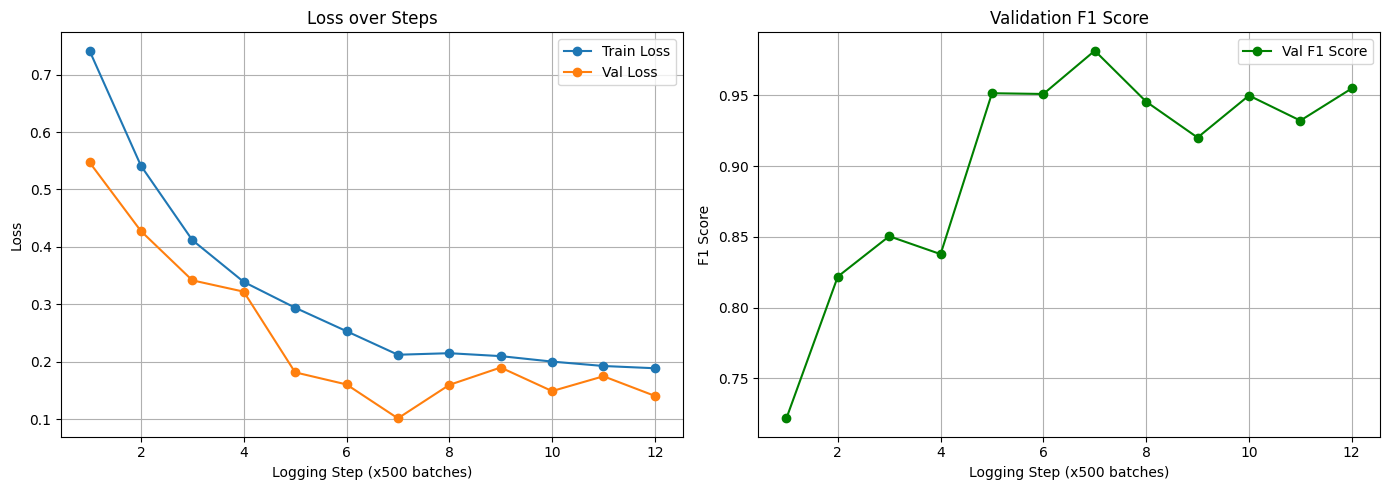

In [ ]:
import matplotlib.pyplot as plt

def visualize_history(history):
    # Create a range of steps based on the recorded data points
    steps = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, history["train_loss"], label="Train Loss", marker="o")
    if "val_loss" in history:
        plt.plot(steps, history["val_loss"], label="Val Loss", marker="o")
    plt.title("Loss over Steps")
    plt.xlabel("Logging Step (x500 batches)")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Plot 2: F1 Score
    plt.subplot(1, 2, 2)
    if "val_f1" in history:
        plt.plot(steps, history["val_f1"], label="Val F1 Score", marker="o", color="green")
    plt.title("Validation F1 Score")
    plt.xlabel("Logging Step (x500 batches)")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run it
visualize_history(history)

# Grad-CAM
Visualize how the model reasons.

In [ ]:
!pip install timm albumentations grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f1195516e5c66f68106b7da2d0f3c3647c78c71f979dfb50905b3fafec5db634
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# Configuration
IMG_SIZE = 384
NUM_CLASSES = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CLASS_NAMES = {0: "Human", 1: "AI"}
MODEL_PATH = "/content/drive/MyDrive/hybrid_model.pth"
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
MAX_IMAGES = 10

# Initialize the Hybrid Model
model = HybridFIREModel(num_classes=NUM_CLASSES).to(DEVICE)

# Load model weights
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Loaded {MODEL_PATH} successfully!")
else:
    print(f"ERROR: Could not find {MODEL_PATH}. Check directory.")

model.eval()

print("Generating Hybrid Model Grad-CAMs...")
model.eval()

Loaded /content/drive/MyDrive/hybrid_model.pth successfully!
Generating Hybrid Model Grad-CAMs...


HybridFIREModel(
  (branch_rgb): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            

In [ ]:
# Wrapper for RGB branch Grad-CAM
class RGBGradCAMWrapper(nn.Module):
    def __init__(self, model):
        super(RGBGradCAMWrapper, self).__init__()
        self.model = model

    def forward(self, x_rgb):
        x_fft = fft_from_rgb(x_rgb)
        return self.model(x_rgb, x_fft)

# Wrapper for FFT branch Grad-CAM
class FFTGradCAMWrapper(nn.Module):
    def __init__(self, model, rgb_input):
        super(FFTGradCAMWrapper, self).__init__()
        self.model = model
        self.rgb_input = rgb_input.detach()

    def forward(self, x_fft):
        return self.model(self.rgb_input, x_fft)

def visualize_hybrid_gradcam(model, rgb_input_tensor, fft_input_tensor, original_rgb_image, original_fft_image, label, prediction, filename, class_names, save_dir="gradcam_hybrid"): # Modified signature
    os.makedirs(save_dir, exist_ok=True)

    # Initialize wrappers and GradCAM instances for each branch
    rgb_wrapper = RGBGradCAMWrapper(model)
    fft_wrapper = FFTGradCAMWrapper(model, rgb_input_tensor)

    target_layers_rgb = [model.branch_rgb.blocks[-1]]
    target_layers_fft = [model.branch_fft.layer4[-1]]

    cam_rgb = GradCAM(model=rgb_wrapper, target_layers=target_layers_rgb)
    cam_fft = GradCAM(model=fft_wrapper, target_layers=target_layers_fft)

    # Generate heatmaps
    grayscale_cam_rgb = cam_rgb(input_tensor=rgb_input_tensor, targets=None)[0, :]
    grayscale_cam_fft = cam_fft(input_tensor=fft_input_tensor, targets=None)[0, :]

    # Visualize heatmaps on respective original images
    visualization_rgb = show_cam_on_image(original_rgb_image, grayscale_cam_rgb, use_rgb=True)
    visualization_fft = show_cam_on_image(original_fft_image, grayscale_cam_fft, use_rgb=True)

    label_str = class_names.get(label, str(label))
    pred_str = class_names.get(prediction, str(prediction))

    if str(label) == str(prediction):
        status = "CORRECT"
        color = "green"
    else:
        status = "WRONG"
        color = "red"

    info_text_rgb = f"RGB Grad-CAM | True: {label_str}, Pred: {pred_str} ({status})"
    info_text_fft = f"FFT Grad-CAM | True: {label_str}, Pred: {pred_str} ({status})"

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    # Original RGB and GradCAM RGB
    axes[0, 0].imshow(original_rgb_image)
    axes[0, 0].set_title(f"Original RGB ({filename})", fontsize=10)
    axes[0, 0].set_xticks([])
    axes[0, 0].set_yticks([])
    axes[0, 1].imshow(visualization_rgb)
    axes[0, 1].set_title(info_text_rgb, color=color, fontsize=10, fontweight='bold')
    axes[0, 1].set_xticks([])
    axes[0, 1].set_yticks([])
    # Original FFT and GradCAM FFT
    axes[1, 0].imshow(original_fft_image)
    axes[1, 0].set_title("Original FFT (Log-Magnitude Spectrum)", fontsize=10)
    axes[1, 0].set_xticks([])
    axes[1, 0].set_yticks([])
    axes[1, 1].imshow(visualization_fft)
    axes[1, 1].set_title(info_text_fft, color=color, fontsize=10, fontweight='bold')
    axes[1, 1].set_xticks([])
    axes[1, 1].set_yticks([])
    plt.tight_layout()

    # Save
    save_path = os.path.join(save_dir, f"DUAL_{status}_{filename}")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close()

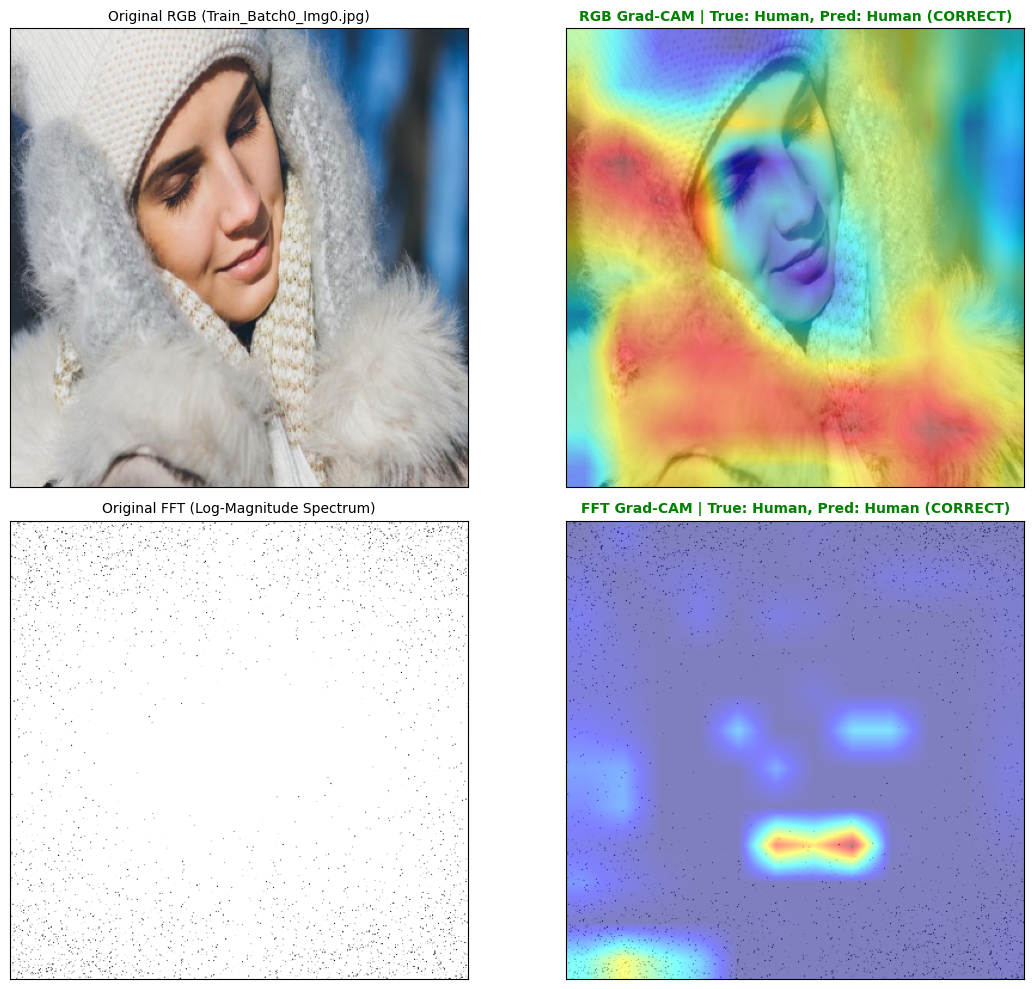

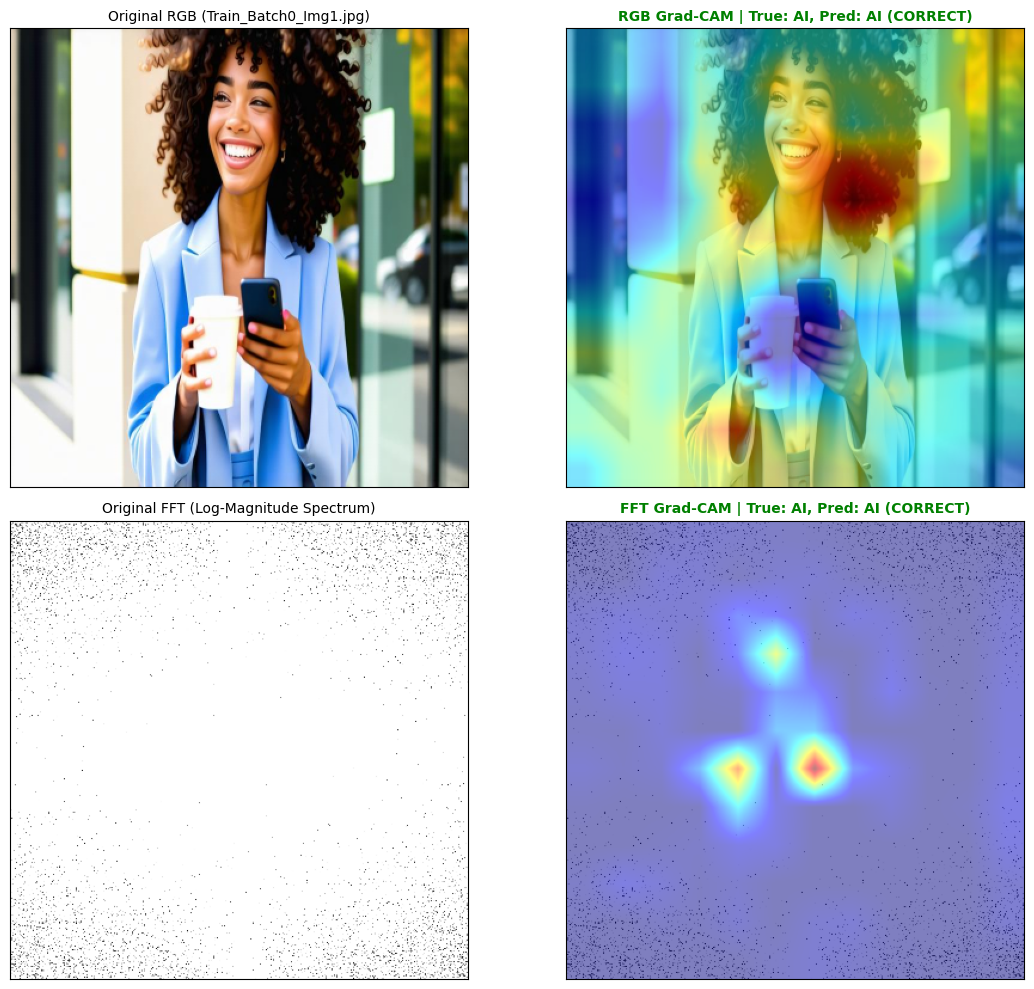

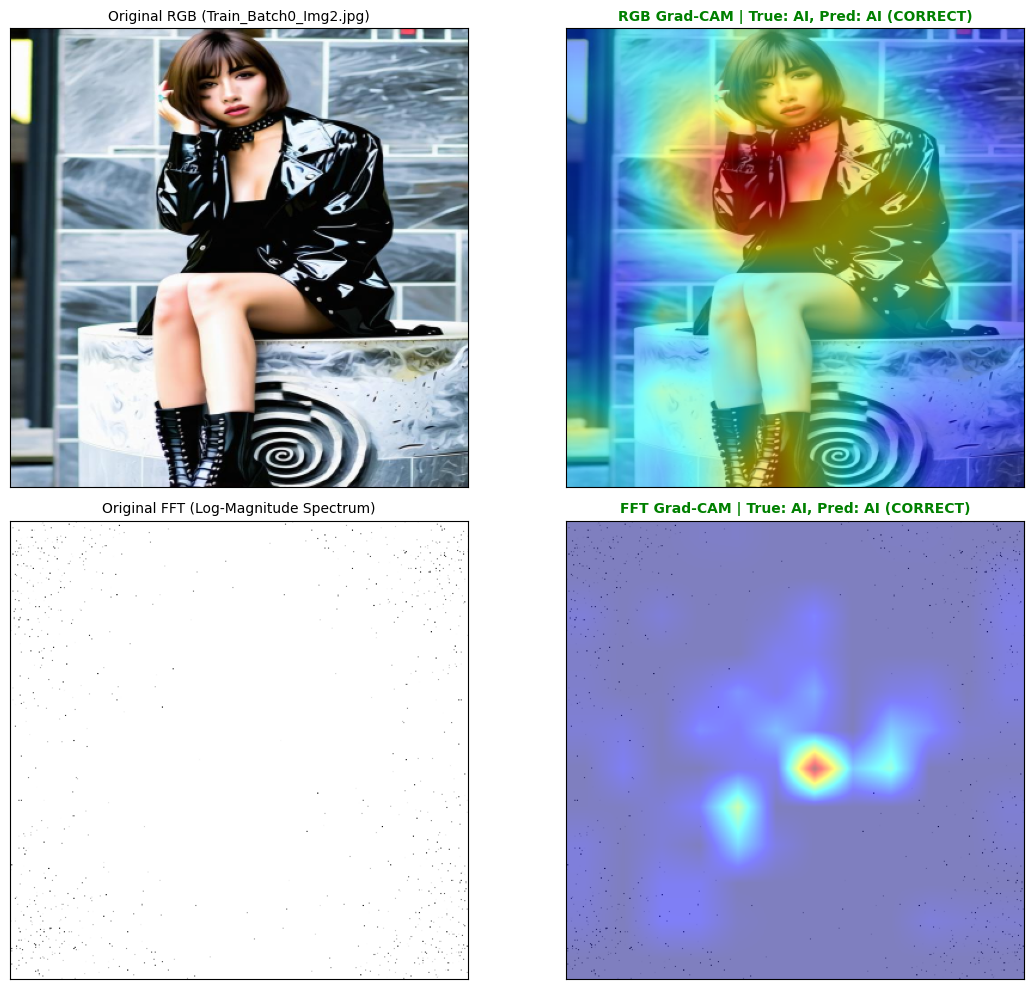

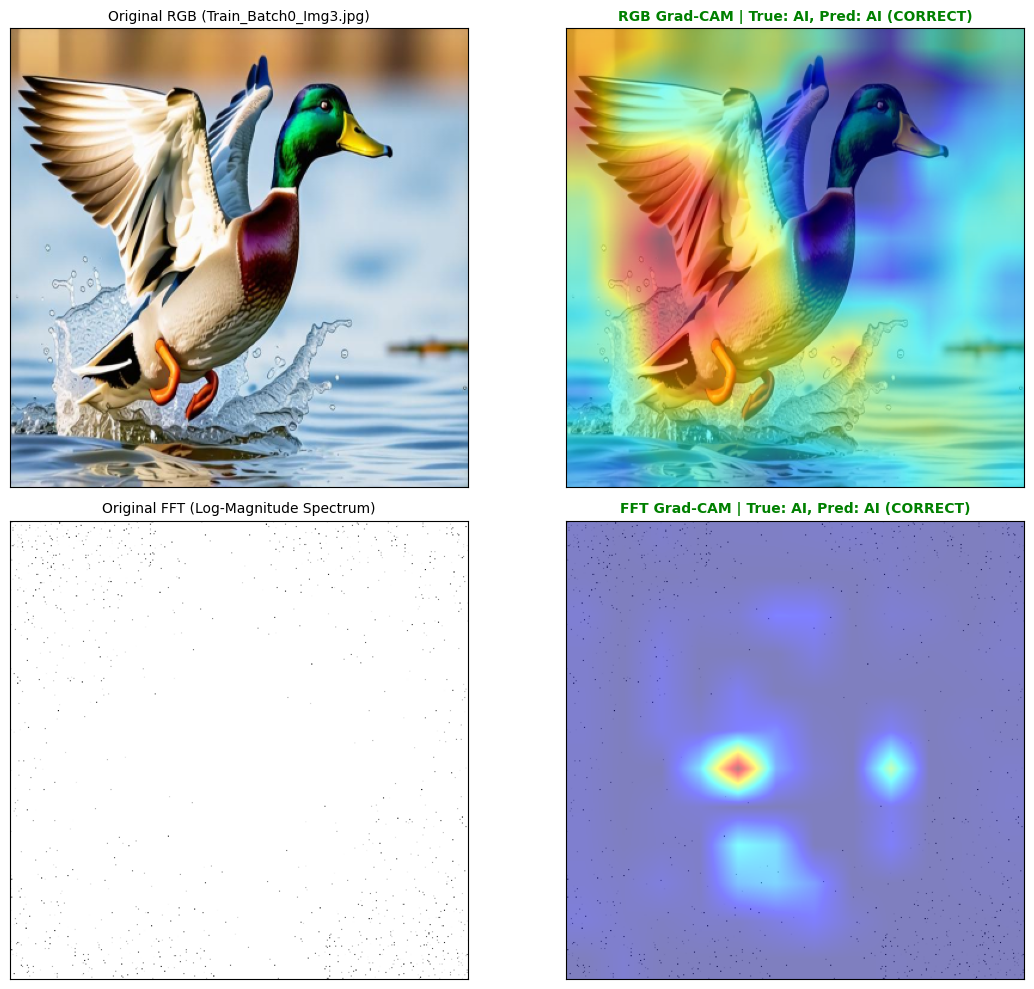

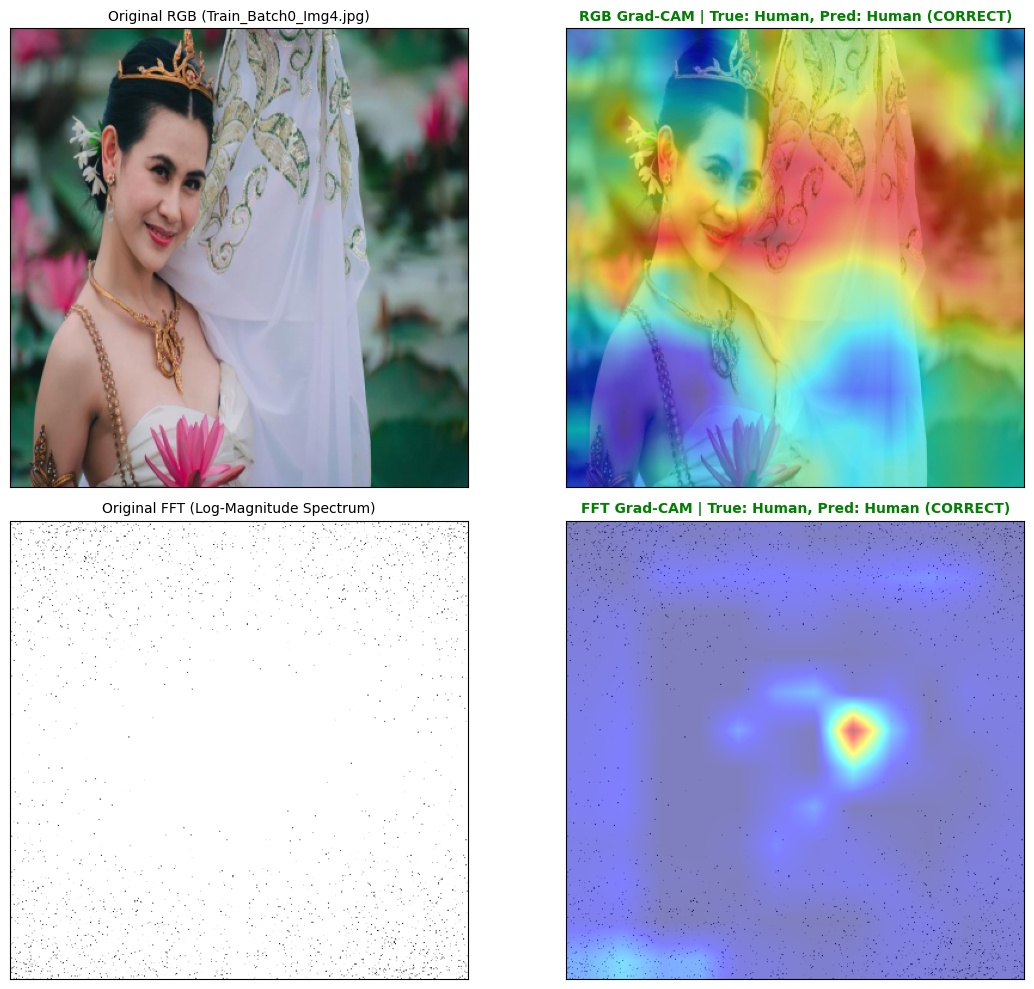

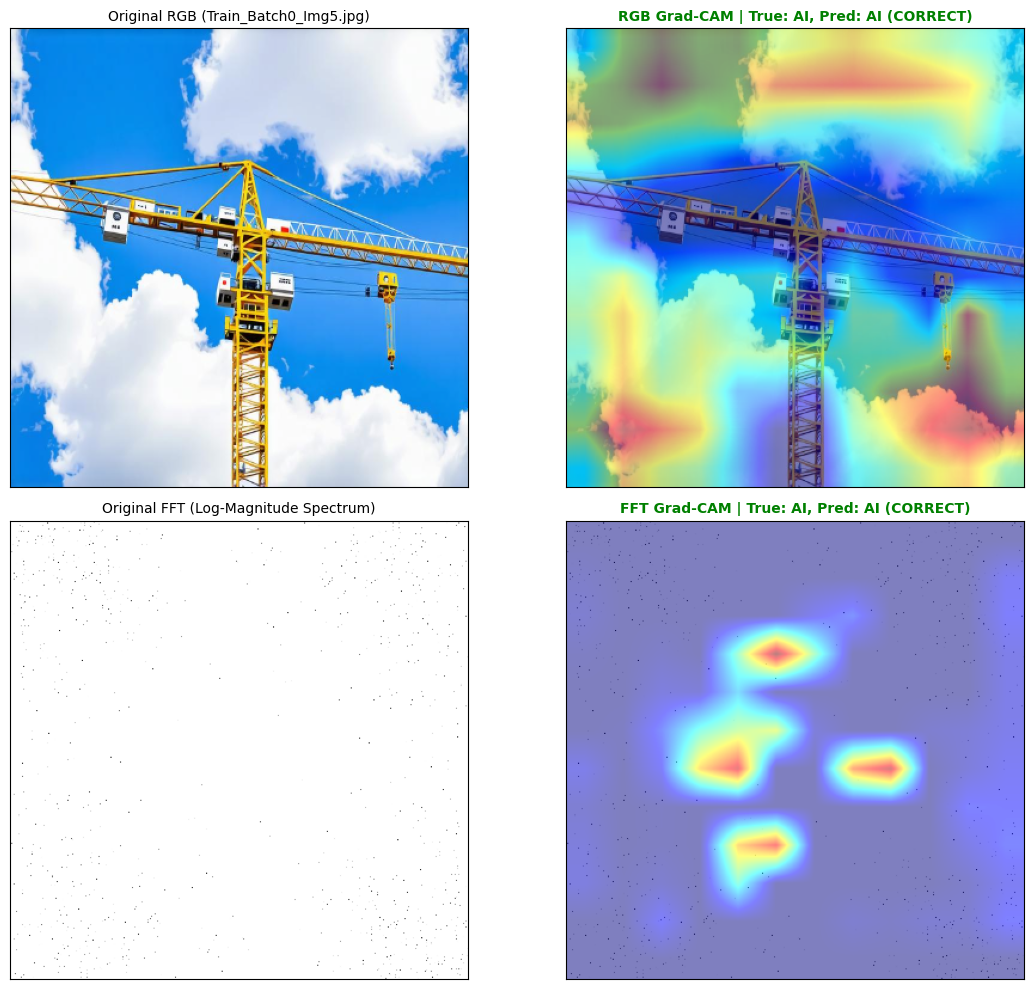

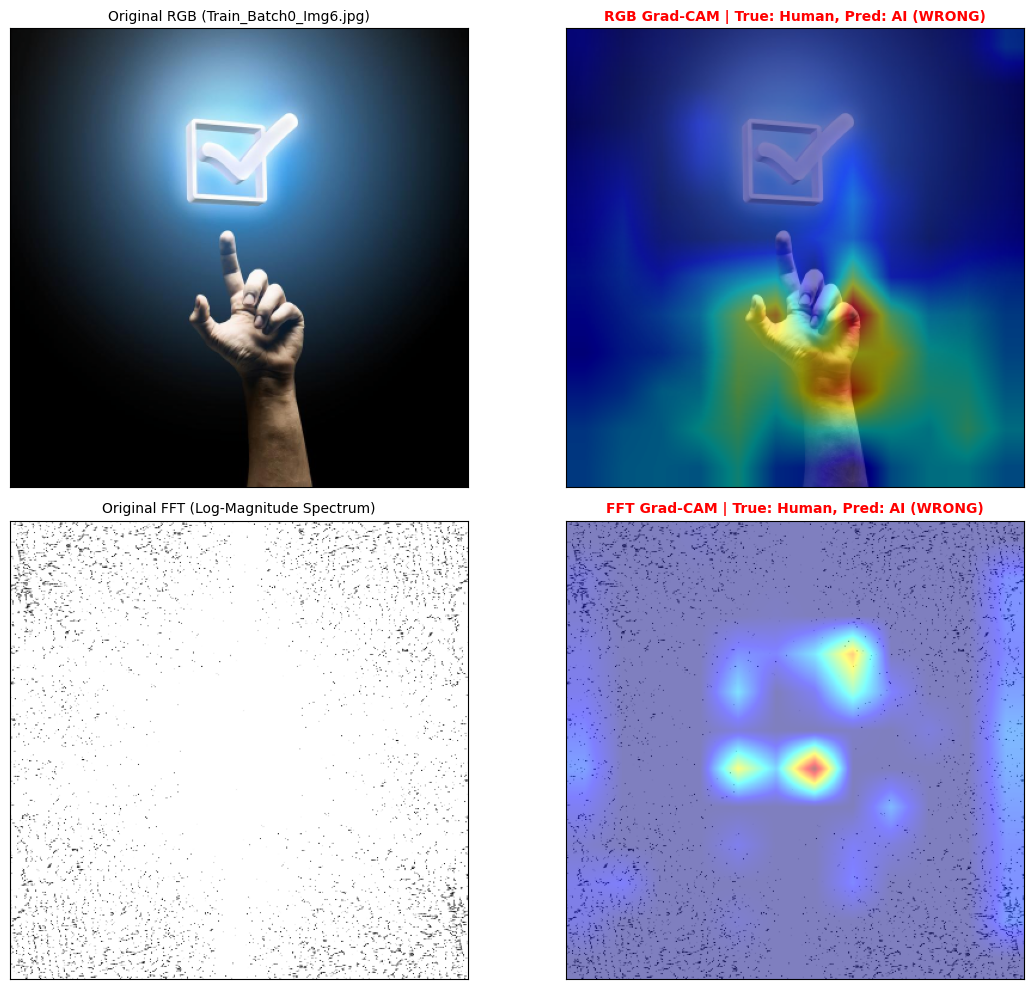

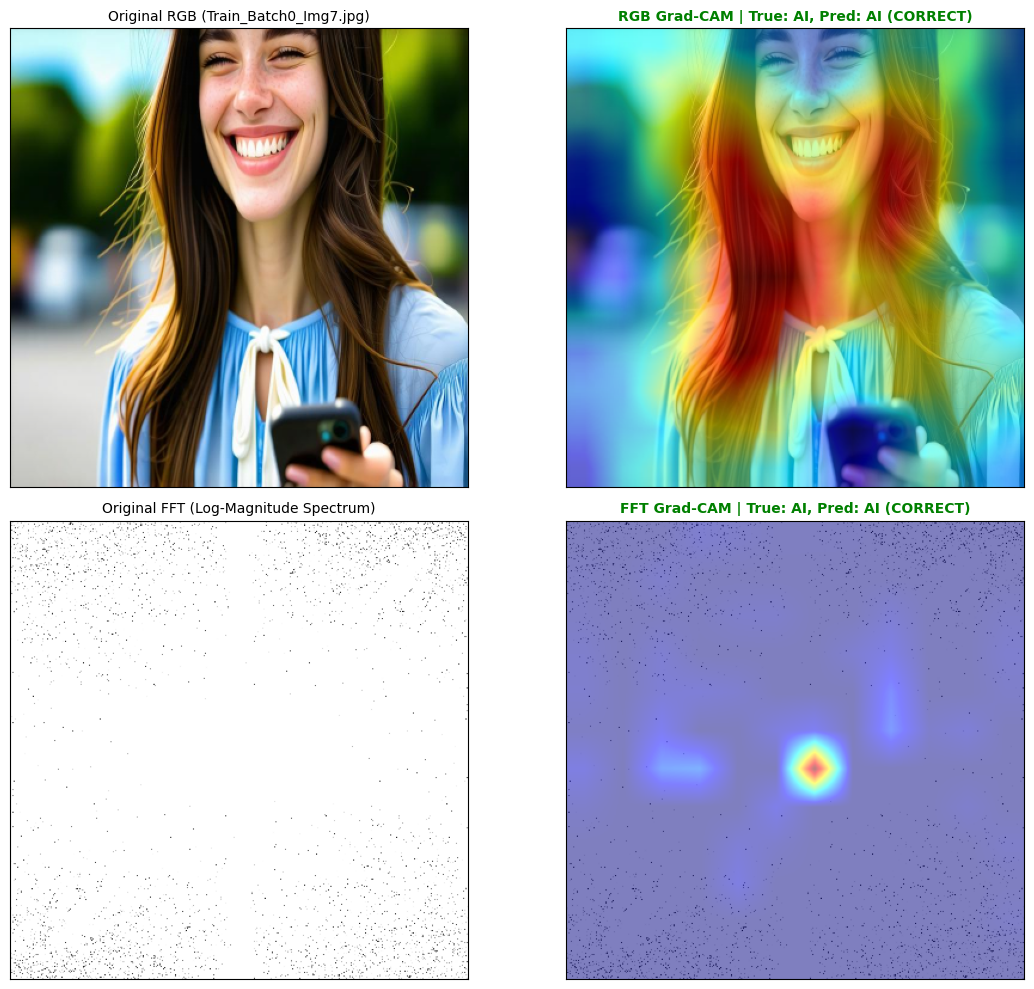

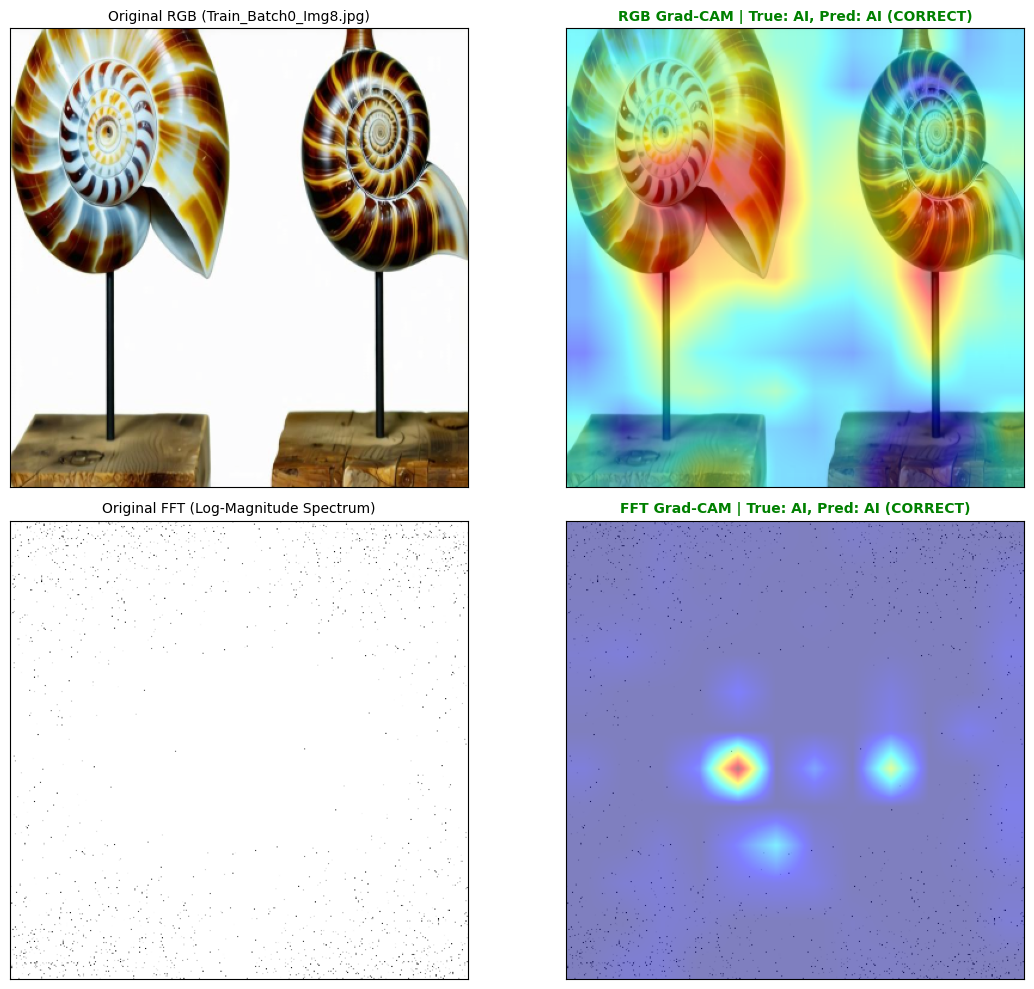

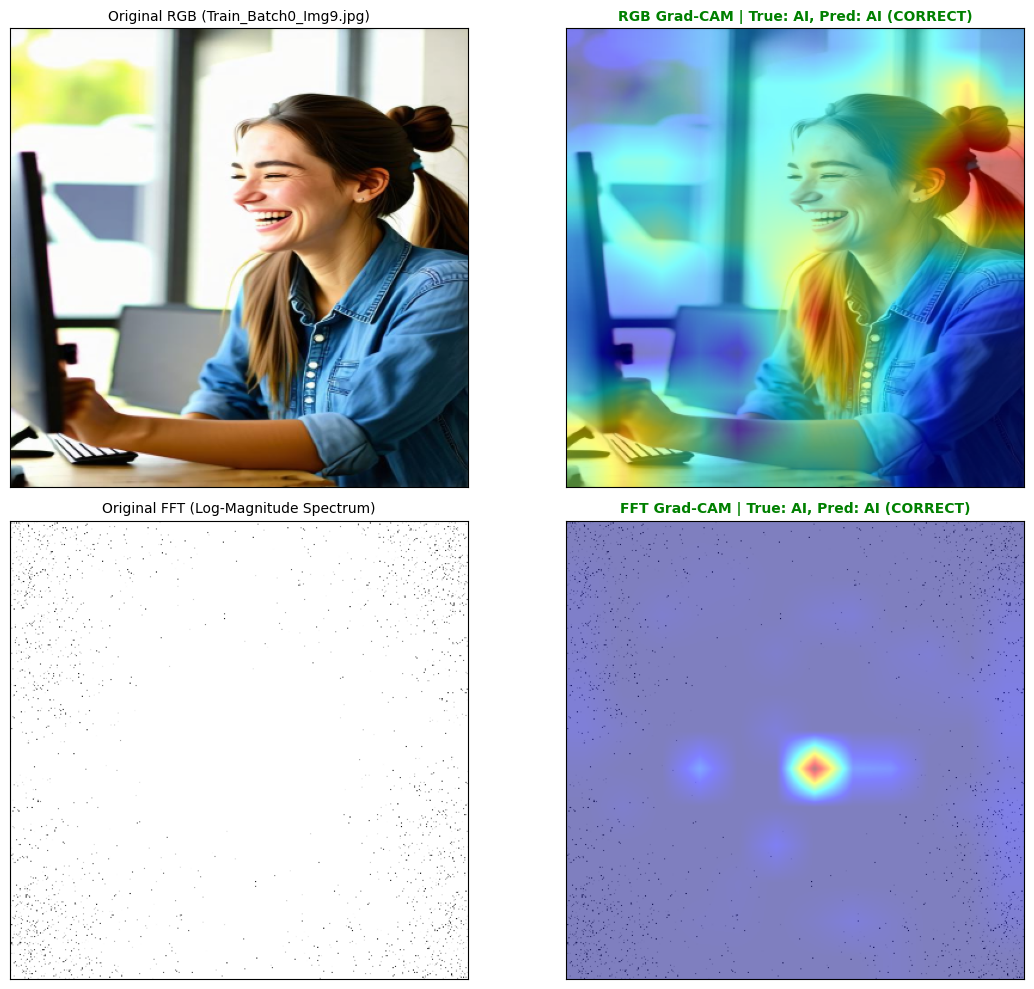

In [ ]:
count = 0

for batch_idx, (rgb_imgs, fft_imgs, labels) in enumerate(train_dataloader):
    rgb_imgs, fft_imgs, labels = rgb_imgs.to(DEVICE), fft_imgs.to(DEVICE), labels.to(DEVICE)

    # Get preds
    with torch.no_grad():
        outputs = model(rgb_imgs, fft_imgs)
        _, preds = torch.max(outputs, 1)

    for i in range(len(rgb_imgs)):
        if count >= MAX_IMAGES:
            break

        # Prepare inputs and denormalize
        rgb_input_tensor = rgb_imgs[i].unsqueeze(0).requires_grad_(True)
        fft_input_tensor = fft_imgs[i].unsqueeze(0).requires_grad_(True)
        original_rgb_image = rgb_imgs[i].cpu().permute(1, 2, 0).numpy()
        original_rgb_image = original_rgb_image * STD + MEAN
        original_rgb_image = np.clip(original_rgb_image, 0, 1)
        original_fft_image = fft_imgs[i].cpu().permute(1, 2, 0).numpy()
        original_fft_image = original_fft_image * STD + MEAN
        original_fft_image = np.clip(original_fft_image, 0, 1)

        current_label = labels[i].item()
        current_pred = preds[i].item()
        dummy_filename = f"Train_Batch{batch_idx}_Img{i}.jpg"

        # Run gradCAM
        visualize_hybrid_gradcam(
            model=model,
            rgb_input_tensor=rgb_input_tensor,
            fft_input_tensor=fft_input_tensor,
            original_rgb_image=original_rgb_image,
            original_fft_image=original_fft_image,
            label=current_label,
            prediction=current_pred,
            filename=dummy_filename,
            class_names=CLASS_NAMES
        )

        count += 1

    if count >= MAX_IMAGES:
        break
